# Deep Learning Brain Tumor Detection

## Imports

In [59]:
#Import scencial libreries
import numpy as np 
import pandas as pd


#For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Models
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Rescaling, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import TrueNegatives, TruePositives, FalseNegatives, FalsePositives, binary_accuracy, Recall, AUC, BinaryAccuracy, Precision
from keras.metrics import accuracy
from keras.applications.vgg16 import VGG16


## Load dataset

In [37]:
data_dir = 'brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'


batch_size = 64
img_height = 180
img_width = 180

In [44]:
train_df = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
    shuffle = True,
)

val_df = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)
class_names = train_df.class_names

Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.


## First show examples of this dataset

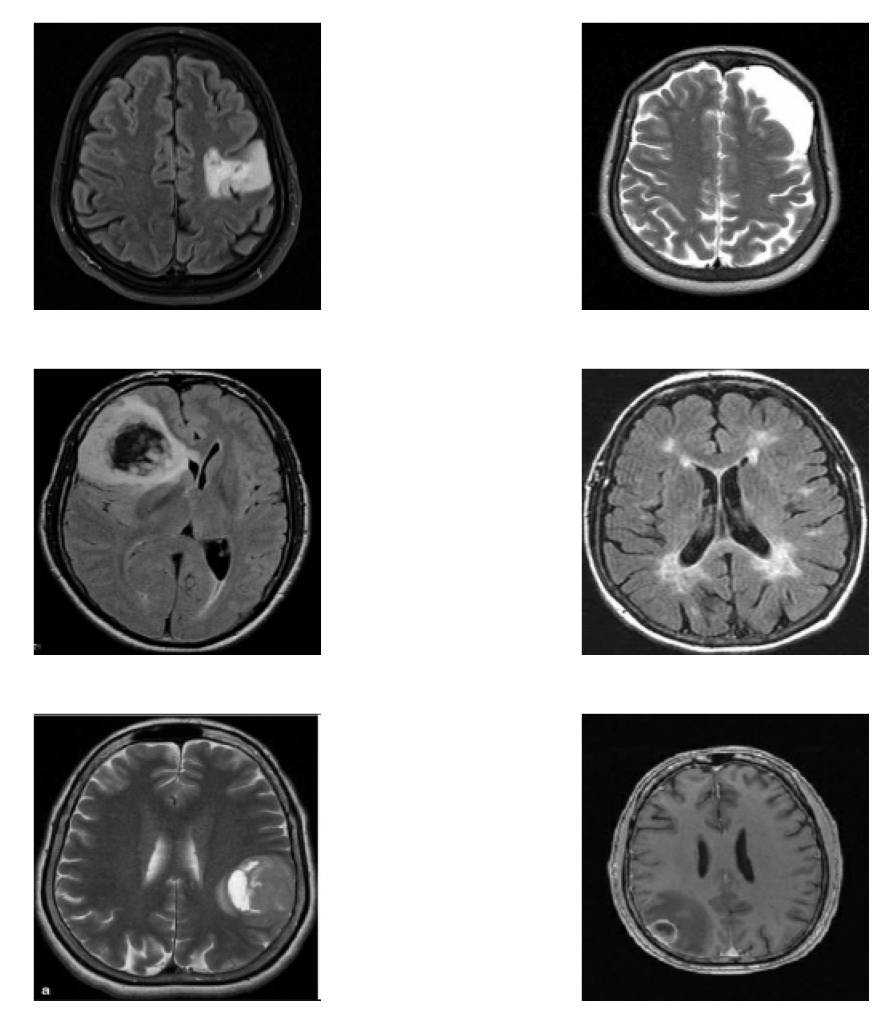

In [51]:
plt.figure(figsize=(18, 18))
with plt.style.context('dark_background'):
    for image_batch, labels_batch in train_df.take(1):
        for i in range(6):
            ax = plt.subplot(3, 2, i+1)
            plt.imshow(image_batch[i].numpy().astype('uint8'))
            plt.title(class_names[labels_batch[i]]) 

## Normalize data 

In [55]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_df = train_df.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_df))
first_image = image_batch[0]

## Create a first model

In [60]:
model = keras.Sequential([
    
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same', input_shape=(img_height,img_width, 3)),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])

In [61]:
metrics = [
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'), 
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),

]

In [62]:
# Compile
model.compile(optimizer = 'adam',
                loss = "binary_crossentropy",
                metrics=metrics)

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 22, 22, 128)     

In [67]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=5)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, verbose=1, mode='auto')

cb = [checkpoint, early]

In [68]:
history = model.fit(train_df, epochs=30,validation_data=val_df, callbacks=cb)

Epoch 1/30
4/4 [==============================] - 6s 1s/step - loss: 0.1062 - tp: 120.0000 - fp: 6.0000 - tn: 74.0000 - fn: 3.0000 - accuracy: 0.9557 - precision: 0.9524 - recall: 0.9756 - auc: 0.9947 - val_loss: 0.7446 - val_tp: 25.0000 - val_fp: 5.0000 - val_tn: 13.0000 - val_fn: 7.0000 - val_accuracy: 0.7600 - val_precision: 0.8333 - val_recall: 0.7812 - val_auc: 0.8307
Epoch 2/30
4/4 [==============================] - 6s 1s/step - loss: 0.0821 - tp: 123.0000 - fp: 2.0000 - tn: 78.0000 - fn: 0.0000e+00 - accuracy: 0.9901 - precision: 0.9840 - recall: 1.0000 - auc: 0.9955 - val_loss: 0.8582 - val_tp: 30.0000 - val_fp: 7.0000 - val_tn: 11.0000 - val_fn: 2.0000 - val_accuracy: 0.8200 - val_precision: 0.8108 - val_recall: 0.9375 - val_auc: 0.8299
Epoch 3/30
4/4 [==============================] - 6s 1s/step - loss: 0.0543 - tp: 123.0000 - fp: 2.0000 - tn: 78.0000 - fn: 0.0000e+00 - accuracy: 0.9901 - precision: 0.9840 - recall: 1.0000 - auc: 0.9999 - val_loss: 0.8479 - val_tp: 26.0000 - 

In [69]:
validation_results = model.evaluate(val_df, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)

loss :  1.3665518760681152
tp :  27.0
fp :  5.0
tn :  13.0
fn :  5.0
accuracy :  0.800000011920929
precision :  0.84375
recall :  0.84375
auc :  0.8255208134651184


### Bad recall and acc, only 0.8%

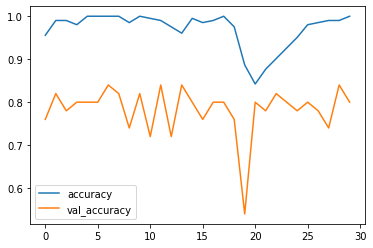

In [71]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['accuracy','val_accuracy']].plot();

## Second model

In [85]:
model = keras.Sequential([
    
    preprocessing.RandomFlip('horizontal'),
    
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same', input_shape=[128, 128, 3]),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])

In [86]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [88]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=30,
    min_delta=0.001,
    restore_best_weights=True,
)

In [89]:
history = model.fit(train_df, epochs=200,validation_data=val_df,batch_size = 64, callbacks=cb, verbose=(2))

Epoch 1/200
4/4 - 5s - loss: 0.5489 - accuracy: 0.7438 - val_loss: 0.6324 - val_accuracy: 0.7800 - 5s/epoch - 1s/step
Epoch 2/200
4/4 - 5s - loss: 0.5393 - accuracy: 0.7438 - val_loss: 0.5815 - val_accuracy: 0.7200 - 5s/epoch - 1s/step
Epoch 3/200
4/4 - 6s - loss: 0.4746 - accuracy: 0.7685 - val_loss: 0.5807 - val_accuracy: 0.8000 - 6s/epoch - 1s/step
Epoch 4/200
4/4 - 6s - loss: 0.5027 - accuracy: 0.7833 - val_loss: 0.5554 - val_accuracy: 0.8000 - 6s/epoch - 1s/step
Epoch 5/200
4/4 - 6s - loss: 0.4476 - accuracy: 0.8030 - val_loss: 0.5521 - val_accuracy: 0.8000 - 6s/epoch - 1s/step
Epoch 6/200
4/4 - 6s - loss: 0.4334 - accuracy: 0.8079 - val_loss: 0.5645 - val_accuracy: 0.8200 - 6s/epoch - 1s/step
Epoch 7/200
4/4 - 6s - loss: 0.4304 - accuracy: 0.8177 - val_loss: 0.5615 - val_accuracy: 0.8000 - 6s/epoch - 1s/step
Epoch 8/200
4/4 - 6s - loss: 0.4013 - accuracy: 0.8177 - val_loss: 0.5706 - val_accuracy: 0.8000 - 6s/epoch - 1s/step
Epoch 9/200
4/4 - 6s - loss: 0.3999 - accuracy: 0.8374 -

loss :  0.9325836300849915
accuracy :  0.800000011920929


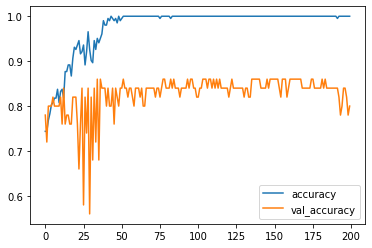

In [90]:
validation_results = model.evaluate(val_df, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)
  
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['accuracy','val_accuracy']].plot();

In [92]:
model.save_weights("model.h5")